# Libraries

In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from scipy.stats import norm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

# First Steps

1. Get some stock market data
2. Save it in csv
3. Transform into useable format (keep as price? transform into percent change? per day?)
4. Define Neural Network Structure
5. Create Neural Network


Keeping stock prices in their standard format would allow each entry to serve as ground truth, while a percentage change would be a relative system. To find a stock change from day X to day Y would require recursively multiplying all percentage changes from day Y back to day X.

Keeping stock prices in percentage change format would help automatically account for stock splits. Adjusted price already accounts for this, but I don't want to use the adjusted price because I don't understand it enough.

## Get some stock market data

I expect the easiest way to do this is with yfinance, though I might look at some other options because yfinance isn't as well maintained as some more professional open source libraries, and it no longer links to a formal yahoo API.

Polygon.io seems promising, but the free version only has 5 API calls per minute (not sure the extent of data I can grab with a single API call, but it doesn't sound like very much), and I can only access two years of historical data.

I'll probably stick with yfinance for now. It's the easiest.

I've done some work with yfinance and one of the difficulties is that it pulls data into a **multi-index dataframe**. I'll have to **transform it into something tidy**.

I'm going to start simple and get a dataset from the DJIA (Dow Jones Industrial Average). It represents a significant portion of the market and it's a good starting point without getting too much in the weeds of big stock data with larger indexes like the S&P 500 or the Wilshire 5000.

Some obstacles to grapple with are:
- **how to handle companies which were bankrupted**. If I don't include these, then the dataset will suffer heavily from survivorship bias.
- **how to handle companies which were merged**. A merged company doesn't go out of business (and so is probably still a good investment) but **representing the change in stock price from the merge** might be difficult.

I found a list of all companies ever listed on the DJIA, but it's stored in a Wikipedia article where the changes are grouped as companies listed on the DJIA on a certain date. There is some text about which companies are moved / merged, but I'll have to parse the complete list with some programming.

There's also the issue of how far to go back for good training data. The DJIA goes back all the way to 1896, but I don't need data back that far for training. Out of convenience, let's have an 80/20 train-test split, where the training set is 40 years, and the testing set is 10 years.

I won't pull until today - that seems ridiculous. Let's set the test cutoff to be December 31, 2023. That means the first training observation will be from January 1, 1973. I don't need to pull data from before then, and I don't need to pull companies listed on the DJIA before then.

### Get company names

In [2]:
# DJIA history URL
djia_hist_comps = pd.read_html('https://en.wikipedia.org/wiki/Historical_components_of_the_Dow_Jones_Industrial_Average')

In [3]:
# combine all dataframes
djia_hist_comps_30_only = djia_hist_comps[1].iloc[:10, :]
for df in djia_hist_comps[2:25]:
    djia_hist_comps_30_only = pd.concat(
        [djia_hist_comps_30_only, df.iloc[:10, :]],
        axis='index',
        copy=False,
        ignore_index=True
    )
display(djia_hist_comps_30_only.sample(8))

,0,1,2
65,Chevron Corporation,Johnson & Johnson,United Technologies Corporation
27,The Coca-Cola Company,"Merck & Co., Inc.","Walgreens Boots Alliance, Inc."
137,Citigroup Inc.,International Business Machines Corporation,Verizon Communications Inc. ↑
155,Caterpillar Inc.,Intel Corporation ↑,The Procter & Gamble Company
179,E.I. du Pont de Nemours & Company,"Merck & Co., Inc.",F. W. Woolworth Company
216,E.I. du Pont de Nemours & Company,International Paper Company,United States Steel Corporation
3,Apple Inc.,Intel Corporation,"The Travelers Companies, Inc."
99,The Coca-Cola Company,Kraft Foods Inc.,The Walt Disney Company


In [4]:
# keeps only company name (removes arrows, subscripts, and extraneous info)
def remove_name_clutter(company_name):
    return re.sub(r"(?:\([^\(\)]*\)|\[[^\[\]]*\])|[^a-zA-Z0-9\s&]", '', company_name)

In [5]:
# convert to list of company names
djia_hist_comps_30_only = djia_hist_comps_30_only.to_numpy().flatten().tolist()

In [6]:
# get only pure company names
djia_hist_comps_30_only = [remove_name_clutter(name).strip() for name in djia_hist_comps_30_only]

In [7]:
# get distinct company names
djia_hist_comps_30_only = set(djia_hist_comps_30_only)

In [8]:
# manual removal of explicit duplicates
duplicates = [
    'UnitedHealth Group Incorporated'
]
for d in duplicates:
    djia_hist_comps_30_only.remove(d)

In [9]:
# convert to list
djia_hist_comps_30_only = sorted(list(djia_hist_comps_30_only))
djia_hist_comps_30_only[:8]

['3M Company',
 'AT&T Corporation',
 'AT&T Inc',
 'Alcoa Inc',
 'Allied Chemical Corporation',
 'AlliedSignal Incorporated',
 'Altria Group Incorporated',
 'Aluminum Company of America']

There are a few companies which are probably indistinguishably duplicates (like AT&T Corporation and AT&T Inc) but because of rebranding or mergers, the companies might be listed differently. I'll need to look into this more.

### Get company tickers

I can probably automate some of this, but I expect that I'll have to go through quite a few names in the list manually to find the tickers.

Nevermind. I've been doing some research on trying to automate this and I'm not having a lot of luck. I'll probably just manually go through the list. It'll probably take me a bit but it's all I have to go on right now, and I'll probably just force myself to find a better solution down the line for when I need to pull more companies.

In [10]:
len(djia_hist_comps_30_only)

86

In [11]:
# view company names (first half of list)
np.array(djia_hist_comps_30_only[:45])

array(['3M Company', 'AT&T Corporation', 'AT&T Inc', 'Alcoa Inc',
       'Allied Chemical Corporation', 'AlliedSignal Incorporated',
       'Altria Group Incorporated', 'Aluminum Company of America',
       'American Can Company', 'American Express Company',
       'American International Group Inc',
       'American Telephone and Telegraph Company',
       'American Tobacco Company', 'Amgen Inc',
       'Anaconda Copper Mining Company', 'Apple Inc',
       'Bank of America Corporation', 'Bethlehem Steel Corporation',
       'Caterpillar Inc', 'Chevron Corporation', 'Chrysler Corporation',
       'Cisco Systems Inc', 'Citigroup Inc', 'Dow Inc', 'DowDuPont Inc',
       'EI du Pont de Nemours & Company', 'Eastman Kodak Company',
       'Esmark Corporation', 'Exxon Corporation',
       'Exxon Mobil Corporation', 'F W Woolworth Company',
       'General Electric Company', 'General Foods Corporation',
       'General Motors Corporation', 'Goodyear Tire and Rubber Company',
       'HewlettPa

In [12]:
# company names and tickers
djia_tickers = [
    ('3M Company', 'MMM'),
    ('AT&T Inc', 'T'),
    ('Alcoa Inc', 'AA'),
    ('Honeywell International', 'HON'),
    ('Altria Group Inc', 'MO'),
    ('American Express Company', 'AXP'),
    ('American International Group Inc', 'AIG'),
    ('Amgen Inc', 'AMGN'),
    ('Apple Inc', 'AAPL'),
    ('Bank of America Corporation', 'BAC'),
    ('Caterpillar Inc', 'CAT'),
    ('Chevron Corporation', 'CVX'),
    ('Cisco Systems Inc', 'CSCO'),
    ('Citigroup Inc', 'C'),
    ('Dow Inc', 'DOW'),
    ('DuPont de Nemours Inc', 'DD'),
    ('Eastman Kodak Company', 'KODK'),
    ('Exxon Mobil Corporation', 'XOM'),
    ('General Electric Company', 'GE'),
    ('General Motors Company', 'GM'),
    ('Goodyear Tire and Rubber Company', 'GT'),
    ('HewlettPackard Company', 'HPE'),
    ('Intel Corporation', 'INTC'),
    ('International Business Machines Corporation', 'IBM'),
    ('International Paper Company', 'IP'),
    ('JPMorgan Chase Co', 'JPM')
]

Noted Changes:
- No separate tickers between 'AT&T Corporation' and 'AT&T Inc'. Several tickers for the company appear, but they look like separate divisions / asset classes, rather than the company's stock before / after the merge or rename or whatever.
- 'Allied Chemical Corporation' changed its name to 'AlliedSignal Incorporated', which then merged with and became 'Honeywell International'.
- 'Aluminum Company of America' renamed to 'Alcoa Inc'.
- 'American Can Company' merged with financial conglomerate 'Primarica Inc'.
- 'American Telephone and Telegraph Company' changed its name to 'AT&T Corporation' (no surprise there).
- 'American Tobacco Company' was restructured into a holding company called 'American Brands Inc'.
- 'Anaconda Copper Mining Company' was purchased by ARCO and then BP.
- 'Bethlehem Steel Corporation' declared bankruptcy in 2001. This is exactly the kind of company I would want to include in the bot, but alas, I'm not easily finding stock info on them.
- 'Chrysler Corporation' bankrupted and was acquired by Fiat, the US, and Canada (not sure what that means - I'm assuming the stock price reflected the bankruptcy).
- 'DowDuPont Inc' spun off (separated into?) DuPont and Dow Inc.
- 'EI du Pont de Nemours & Company' is assumedly now 'DuPont de Nemours Inc', but how it mingled with Dow, DowDuPont, etc. is beyond me right now.
- 'Esmark Corporation' is interwoven with 'JBS USA', but the two companies are too distinct to keep them properly on this list.
-  There isn't even an article for 'F W Woolworth Company', much less a ticker.
- 'Exxon Corporation', as expected, has no immediate difference from 'Exxon Mobil Corporation'.
- 'General Foods Corporation' was combined into 'Kraft Foods Inc'.
- 'Honeywell International Inc' and 'Honeywell International' are the same company.
- 'Inco Limited' was delisted and is a subsidiary of 'Vale'.
- 'International Harvester Company' was renamed to 'Navistar Inc', which is a subsidiary of 'Traton'.
- 'International Nickel Company Ltd' changed its name to 'Inco Limited' (listed above).
- 'JP Morgan & Company' is part of 'JPMorgan Chase & Co'.

A lot of the companies have merged, changed tickers, changed names, gone bankrupt, changed exchanges, etc. Which affects how easily I can access their historical data.

I've done a little research and it looks like I can probably find some data via Library of Congress (though I need to locate a public or academic library that has access to the financial records database). There's also probably newspaper databases, though I don't want to comb through those now (or at all).

I expect that I will need to account for these variables at some point, but for right now, I'm going to stick with the stocks that are easily available. It's not great for the survivorship bias (which was the whole point) but it'll be better than ignoring it entirely. Besides, this is more of an exercise in exploring how a neural network might be able to make sense of the vast interconnectedness of the stock market, rather than getting a useable stock bot immediately.

In [13]:
# view company names (second half of list)
np.array(djia_hist_comps_30_only[45:])

array(['JPMorgan Chase & Co', 'JohnsManville Corporation',
       'Johnson & Johnson', 'Kraft Foods Inc', 'McDonalds Corporation',
       'Merck & Co Inc', 'Microsoft Corporation',
       'Minnesota Mining & Manufacturing Company',
       'Navistar International Corporation', 'Nike Inc',
       'OwensIllinois Inc', 'Pfizer Inc', 'Philip Morris Companies Inc',
       'Raytheon Technologies Corporation', 'SBC Communications Inc',
       'Salesforce Inc', 'Sears Roebuck & Company',
       'Standard Oil Co of California', 'Standard Oil Co of New Jersey',
       'Swift & Company', 'Texaco Incorporated', 'The Boeing Company',
       'The CocaCola Company', 'The Goldman Sachs Group Inc',
       'The Home Depot Inc', 'The Procter & Gamble Company',
       'The Travelers Companies Inc', 'The Walt Disney Company',
       'Travelers Inc', 'USX Corporation', 'Union Carbide Corporation',
       'United Aircraft Corporation', 'United States Steel Corporation',
       'United Technologies Corporation

In [14]:
# company names and tickers (for second half of list)
djia_tickers.extend([
    ('Johnson & Johnson', 'JNJ'),
    ('McDonalds Corporation', 'MCD'),
    ('Merck & Co Inc', 'MRK'),
    ('Microsoft Corporation', 'MSFT'),
    ('Nike Inc', 'NKE'),
    ('OI Glass Inc', 'OI'),
    ('Pfizer Inc', 'PFE'),
    ('Philip Morris International Inc', 'PM'),
    ('RTX Corporation', 'RTX'),
    ('Salesforce Inc', 'CRM'),
    ('The Boeing Company', 'BOE'),
    ('The Coca-Cola Company', 'KO'),
    ('The Goldman Sachs Group Inc', 'GS'),
    ('The Home Depot Inc', 'HD'),
    ('The Procter & Gamble Company', 'PG'),
    ('The Travelers Companies Inc', 'TRV'),
    ('The Walt Disney Company', 'DIS'),
    ('United States Steel Corporation', 'X'),
    ('UnitedHealth Group Inc', 'UNH'),
    ('Verizon Communications Inc', 'VZ'),
    ('Visa Inc', 'V'),
    ('Walgreens Boots Alliance Inc', 'WBA'),
    ('Walmart Inc', 'WMT')
])

Noted Changes:
- 'Johns Manville Corporation' filed for bankruptcy and was acquired by 'Berkshire Hathaway'.
- 'Kraft Foods Inc' is a subcompany of 'Kraft Heinz'.
- 'Minnesota Mining & Manufacturing Company' changed its name to '3M Company'.
- 'Navistar' is a subsidiary (see above).
- 'OwensIllinois Inc' changed its name to 'O-I Glass Inc'.
- 'Raytheon Technologies Corporation' was renamed to 'RTX Corporation'.
- 'SBC Communications Inc' acquired and renamed to 'AT&T'.
- 'Sears Roebuck and Co' bankrupted and was acquired.
- 'Standard Oil Co of California' was renamed to 'Chevron Corporation'.
- 'Standard Oil Co of New Jersey' was renamed to 'Exxon Corporation'.
- 'Swift & Company' was renamed to 'Esmark Corporation' (see above).
- 'Texaco' is a subsidiary of 'Chevron'.
- 'Travelers Inc' was merged with Citicorp to become 'Citigroup'.
- 'USX Corporation' is the 'United States Steel Corporation'.
- 'United Technologies Corporation' merged with Raytheon to become 'Raytheon Technologies' (see above).
- 'Union Carbide Corporation' was acquired by 'Dow Chemical'.
- 'United Aircraft Corporation' was renamed to 'United Technologies Corporation'.
- 'WalMart Stores Inc' is the same as 'Walmart Inc'.
- 'Westinghouse Electric Corporation' was merged into 'CBS', then 'Viacom'.


In [15]:
len(djia_tickers)

49

Not bad, all things considered. I'll definitely have to look into **reviewing newspaper databases for historical stock info**.

Now I have to get the stock data for each ticker.

### Get data for each ticker

I found a [good article](https://www.qmr.ai/yfinance-library-the-definitive-guide/) on using yfinance.

In [16]:
# get tickers only
djia_tickers_only = [x[1] for x in djia_tickers]

In [17]:
# get tickers
tickers = yf.Tickers(djia_tickers_only)

In [18]:
# prepare dataframe
tickers_hist = tickers.history(
    start= '1972-01-01',
    end= '2022-12-31',
    auto_adjust= False
)\
.stack(level=1)\
.rename_axis(['Date','Ticker'])\
.reset_index(level=1)

[*********************100%***********************]  49 of 49 completed


In [19]:
# sort columns for readability
tickers_hist = tickers_hist[[
    'Ticker',
    'Open',
    'High',
    'Low',
    'Close',
    'Adj Close',
    'Volume',
    'Stock Splits',
    'Dividends'
]]

In [20]:
tickers_hist.head()

,Ticker,Open,High,Low,Close,Adj Close,Volume,Stock Splits,Dividends
Date,,,,,,,,,
1972-01-03,AA,4.367953,4.455563,4.355438,4.355438,1.275041,129838.0,0.0,0.0
1972-01-03,CAT,3.937500,3.979167,3.937500,3.937500,1.453360,265200.0,0.0,0.0
1972-01-03,CVX,3.585938,3.625000,3.570313,3.609375,0.557802,542400.0,0.0,0.0
1972-01-03,DIS,1.412956,1.427085,1.387266,1.394973,0.928376,1216422.0,0.0,0.0
1972-01-03,GE,7.834549,7.912738,7.818912,7.881463,1.719223,352511.0,0.0,0.0


In [21]:
tickers_hist.shape

(498498, 9)

Everything looks good here. Roughly 500k records is a solid dataset to work with. I've looked at some of the records for companies whose IPOs were after the start date (Jan 1 1973) and their first records are for their IPO. I'll have to manually **add 0-coded records for those companies whose IPOs happened after the start date**. In the meantime, this should be good to convert to store in a CSV.

## Save it in csv

In [22]:
# convert data to CSV
tickers_hist.to_csv('DJIA_price_history_base.csv')

## Transform into useable format

Now that I have some data, I need to put it into a format I can work with. The actual price probably isn't the best format because the prices are specific to each ticker. I'd like something more standardized.

My thought is to have the prices be represented as a percentage change from the previous day (or week, or month, etc). My overall goal is to use this data to try to predict whether the next day's price will reach a certain threshold.

In [23]:
# get DJIA data
djia = pd.read_csv('DJIA_price_history_base.csv')

display(djia.sample(8))

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Stock Splits,Dividends
443085,2018-06-29,INTC,49.529999,50.110001,49.500000,49.709999,42.963696,28906500.0,0.0,0.0
72161,1982-12-17,JPM,0.000000,9.222222,8.861111,9.166667,1.999012,243000.0,0.0,0.0
330913,2008-12-04,BAC,14.740000,15.360000,13.930000,14.340000,11.802994,107562100.0,0.0,0.0
149364,1991-05-20,JPM,6.250000,6.333333,6.208333,6.250000,2.374644,414600.0,0.0,0.0
271112,2003-05-14,IP,34.974373,35.002392,34.470070,34.675526,16.780722,2782539.0,0.0,0.0
200016,1996-05-28,HON,27.468960,27.588131,26.753933,27.111446,15.148894,1355823.0,0.0,0.0
63684,1981-12-01,MMM,6.781250,6.828125,6.734375,6.781250,1.844720,855200.0,0.0,0.0
99070,1986-01-15,IBM,35.731358,36.508125,35.671604,36.478249,13.843639,5830822.0,0.0,0.0


In [24]:
djia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498498 entries, 0 to 498497
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          498498 non-null  object 
 1   Ticker        498498 non-null  object 
 2   Open          498498 non-null  float64
 3   High          498498 non-null  float64
 4   Low           498498 non-null  float64
 5   Close         498498 non-null  float64
 6   Adj Close     498498 non-null  float64
 7   Volume        498498 non-null  float64
 8   Stock Splits  498498 non-null  float64
 9   Dividends     498498 non-null  float64
dtypes: float64(8), object(2)
memory usage: 38.0+ MB


I could use the adjusted close for now, but I'll have to create something more robust in the future.

The trick now is to create a new Dataframe. I'm considering structuring it so that the companies are the columns/variables and the records are the dates, but I'm not sure how I'm going to approach constructing the tensors for the neural network with this.

First, I think I need to start by initializing zero-coded values for all companies that do not have data going back to January 1, 1972.

In [25]:
# get date for first record for all companies
companies = djia['Ticker'].unique()
listing_dates = []
for ticker in companies:
    listing_date = djia.loc[djia['Ticker'] == ticker]['Date'].min()
    listing_dates.append(listing_date)

first_dates = np.array([companies, listing_dates]).T

first_dates = pd.DataFrame(
    data= first_dates,
    columns= ['name', 'listing_date']
)


In [26]:
# get companies and first dates not listed on or prior to Jan 1, 1972
late_listers = first_dates.loc[first_dates['listing_date'] != djia['Date'].min()]
display(late_listers.sample(5))

,name,listing_date
41,CRM,2004-06-23
37,CSCO,1990-02-16
35,UNH,1984-10-17
31,HD,1981-09-22
48,DOW,2019-03-20


In [27]:
# sort all unique dates (some dates are not market days)
all_dates = djia['Date'].unique()
all_dates.sort()

# initialize data holder
entries_to_add = list()

# append zeroed entries post-1/1/1973 not yet existing for all dates for all companies
for company in late_listers['name'].values:
    listing_date = late_listers.loc[late_listers['name'] == company]['listing_date'].values[0]
    up_to_date_idx = np.where(all_dates == listing_date)[0][0]

    for date in all_dates[:up_to_date_idx]:
        zeroed_entry = [
            date,
            company,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
        ]
        entries_to_add.append(zeroed_entry)

# construct dataframe from data holder
entries_to_add = pd.DataFrame(
    data= entries_to_add,
    columns= djia.columns
)

In [28]:
# concatenate dataframe
djia = pd.concat(
    [djia, entries_to_add],
    ignore_index= True
).sort_values(
    by= ['Ticker', 'Date'],
    ignore_index= True
)

In [32]:
# resave to price history
# djia.to_csv('DJIA_price_history.csv', index= False)

In [7]:
# get saved DJIA price history
djia = pd.read_csv('DJIA_price_history.csv')

djia.sample(8)

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Stock Splits,Dividends
437772,1973-11-05,NKE,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
617748,1973-06-26,XOM,2.980469,3.007813,2.976563,3.007813,0.304446,1331200.0,0.0,0.0
502459,1975-05-05,RTX,0.968573,0.971031,0.951365,0.953823,0.246003,1418659.0,0.0,0.0
44992,1997-05-08,AMGN,15.203125,15.500000,15.125000,15.187500,11.089767,4986800.0,0.0,0.0
66818,1981-12-08,BAC,0.000000,1.953125,1.921875,1.921875,0.668075,512800.0,0.0,0.0
174228,1999-10-18,DIS,23.799313,23.922625,23.059439,23.306063,18.121534,6138469.0,0.0,0.0
96886,1999-02-16,C,263.437500,269.375000,262.812500,267.187500,149.530060,1311380.0,0.0,0.0
167826,1974-06-19,DIS,0.888878,0.911999,0.888878,0.894016,0.594981,720122.0,0.0,0.0


Now it's a matter of converting it into a percentage format. There are some things to keep in mind:
- There will be no change recorded if both days are zero (company is not listed)
- There will be no change recorded if the previous day is zero (company IPO, calculating percentage change would be dividing by zero)
- If using the close to calculate, stock splits or dividends will need to be checked to ensure that close prices reflect the changes properly

For now, I will use the adjusted close for proof of concept, and go from there.

In [8]:
# daily percentage change by company
djia['Percentage Change'] = djia.groupby('Ticker')['Adj Close'].pct_change() * 100

In [9]:
# fill null values
djia['Percentage Change'].fillna(value= 0.0, inplace= True)

In [10]:
# fill infinitys (DIV/0, IPO)
djia.replace(to_replace= np.inf, value= 0.0, inplace= True)

In [11]:
# check any null values in dataframe
djia.isnull().any().any()

False

In [12]:
djia.sample(8)

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Stock Splits,Dividends,Percentage Change
293032,2011-11-23,IBM,172.724670,173.508606,169.713196,170.124283,109.087799,5021741.0,0.0,0.0,-1.853231
612672,2004-04-27,X,36.049999,36.049999,32.580002,33.380001,28.199648,11166000.0,0.0,0.0,-5.971845
542314,1980-05-12,UNH,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
251357,1999-08-17,HD,42.875000,43.083332,41.541668,42.041668,25.979843,4235550.0,0.0,0.0,-1.464813
276424,1997-01-08,HPE,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
248397,1987-11-30,HD,0.567901,0.567901,0.526749,0.539095,0.320499,6245100.0,0.0,0.0,-8.391464
248214,1987-03-11,HD,0.573388,0.573388,0.559671,0.570645,0.338869,7422131.0,0.0,0.0,0.970872
2980,1983-10-19,AA,13.141406,13.216500,12.841031,13.216500,6.294562,965460.0,0.0,0.0,0.571400


In [13]:
# resave to price history
# djia.to_csv('DJIA_price_history_pct.csv', index= False)

Now I have a percentage change column from the previous day for all tickers.

## Define Neural Network Structure

### Starting Ideas

I don't think I should be so quick to jump directly into a neural network. I'm thinking I'll start with something really simple and work my way up.

A few things I would like to try:
1. Predict probability of stock price increasing at all, given price of all stocks from previous day (logistic regression)
2. Predict percentage change of a stock price given price of all stocks from previous day (linear regression)
3. Predict probability of stock price *increasing* X percent given price of all stocks from previous day (logistic regression)
4. Predict probability of stock price *decreasing* X percent given price of all stocks from previous day

In the above, I said "X percent". Let's assume that I have an ambitious goal of doubling my money every quarter. Given that I am aiming for a skewed distribution of returns, where the bulk are positive, I will decide the mean via:

$ A = P(1+{r \over n})^{nt} $

assuming $ P = 1 $ and $ A = 2 $, doubling our funds, <br>
$ n = 1 $ where the interest is applied once per period, and <br>
$ t = 91 $ is the average number of days per quarter, <br>
then:

$ 2 = (1+{r})^{91} $ where $r$ is the daily percentage increase in portfolio value.

$ \sqrt[91]{2} - 1 = r $

$ r = 0.00765 $

so the portfolio value must increase 0.765% every day to double in a quarter.

For simplicity, we can assume a normal distribution of ideal trade returns.

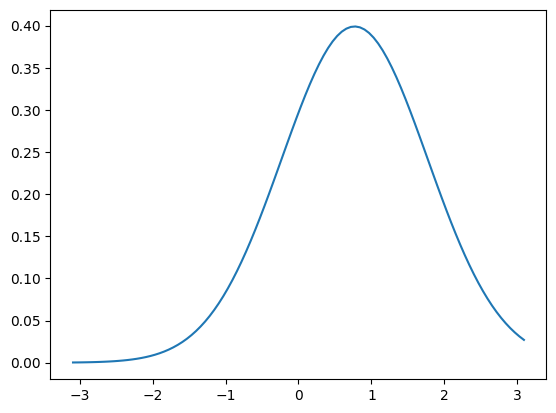

In [6]:
x = np.linspace(
    norm.ppf(0.001),
    norm.ppf(0.999),
    100)
plt.plot(
    x, norm.pdf(x, loc=0.77)
);

So for the "X percent" defined above, we will use 0.765 as "X".

### Transforming the data

Now for 1. above, I need:
- feature matrix: Price changes of previous day for each stock (percentage)
- target vector: price ending positive (int 1|0)

In [2]:
# get data
djia = pd.read_csv("DJIA_price_history_pct.csv")

In [3]:
djia.head()

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Stock Splits,Dividends,Percentage Change
0,1972-01-03,AA,4.367953,4.455563,4.355438,4.355438,1.275041,129838.0,0.0,0.0,0.000000
1,1972-01-04,AA,4.355438,4.455563,4.330406,4.430531,1.297025,56929.0,0.0,0.0,1.724168
2,1972-01-05,AA,4.493109,4.555688,4.493109,4.555688,1.333666,186767.0,0.0,0.0,2.824948
3,1972-01-06,AA,4.555688,4.680844,4.555688,4.655813,1.362975,874906.0,0.0,0.0,2.197684
4,1972-01-07,AA,4.655813,4.655813,4.530656,4.530656,1.326337,332584.0,0.0,0.0,-2.688144


In [4]:
unique_tickers = djia['Ticker'].unique()
print(unique_tickers)

['AA' 'AAPL' 'AIG' 'AMGN' 'AXP' 'BAC' 'BOE' 'C' 'CAT' 'CRM' 'CSCO' 'CVX'
 'DD' 'DIS' 'DOW' 'GE' 'GM' 'GS' 'GT' 'HD' 'HON' 'HPE' 'IBM' 'INTC' 'IP'
 'JNJ' 'JPM' 'KO' 'KODK' 'MCD' 'MMM' 'MO' 'MRK' 'MSFT' 'NKE' 'OI' 'PFE'
 'PG' 'PM' 'RTX' 'T' 'TRV' 'UNH' 'V' 'VZ' 'WBA' 'WMT' 'X' 'XOM']


In [5]:
# Sort the DataFrame by date in ascending order
djia_sorted = djia.sort_values(by=['Ticker', 'Date'])[['Date', 'Ticker', 'Percentage Change']]

djia_sorted.head(8)

,Date,Ticker,Percentage Change
0,1972-01-03,AA,0.000000
1,1972-01-04,AA,1.724168
2,1972-01-05,AA,2.824948
3,1972-01-06,AA,2.197684
4,1972-01-07,AA,-2.688144
5,1972-01-10,AA,0.276170
6,1972-01-11,AA,-0.275409
7,1972-01-12,AA,-1.105013


In [32]:
djia_pivot = djia_sorted.pivot(
    columns= 'Ticker',
    index= 'Date',
    values= 'Percentage Change'
)
djia_pivot.reset_index(inplace= True, col_level= 1)
djia_pivot.index.rename('Index', inplace=True)
djia_pivot.head()

Ticker,Date,AA,AAPL,AIG,AMGN,AXP,BAC,BOE,C,CAT,...,RTX,T,TRV,UNH,V,VZ,WBA,WMT,X,XOM
Index,,,,,,,,,,,,,,,,,,,,,
0,1972-01-03,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1972-01-04,1.724168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529107,...,5.982782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712290
2,1972-01-05,2.824948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789488,...,4.435641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.020214
3,1972-01-06,2.197684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,4.247030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.155099
4,1972-01-07,-2.688144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.740797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.489422


This is an excellent format for everything I need to do with the data in the future. 

In [34]:
# djia_pivot.to_csv('DJIA_pct_change.csv')

### Transforming the data 2

Now that I have the data in a workable format, I need to create my target vector: boolean predictions of the stock going up or down.

In [36]:
djia_pct = pd.read_csv('DJIA_pct_change.csv', index_col= 'Index')

In [37]:
djia_pct.sample()

,Date,AA,AAPL,AIG,AMGN,AXP,BAC,BOE,C,CAT,...,RTX,T,TRV,UNH,V,VZ,WBA,WMT,X,XOM
Index,,,,,,,,,,,,,,,,,,,,,
5246,1992-10-06,0.779714,2.873669,3.252973,2.100851,-0.595282,-0.289841,0.0,0.0,0.254374,...,-0.797839,-0.749091,0.509394,3.807123,0.0,0.0,0.986841,1.091677,4.97247,-0.599986


In [35]:
ticker_prediction_names = [ticker + "_pred" for ticker in unique_tickers]
print(ticker_prediction_names[:5])

['AA_pred', 'AAPL_pred', 'AIG_pred', 'AMGN_pred', 'AXP_pred']


In [52]:
prediction_data_ = np.array([
        [1 if djia_pct.loc[i+1, ticker]>0.0 else 0 for i in range(djia_pct.shape[0]-1)]
    for ticker in unique_tickers]
)
prediction_data = pd.DataFrame(
    data= prediction_data_.T,
    columns= ticker_prediction_names
)

In [54]:
prediction_data.tail()

,AA_pred,AAPL_pred,AIG_pred,AMGN_pred,AXP_pred,BAC_pred,BOE_pred,C_pred,CAT_pred,CRM_pred,...,RTX_pred,T_pred,TRV_pred,UNH_pred,V_pred,VZ_pred,WBA_pred,WMT_pred,X_pred,XOM_pred
12856,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
12857,1,0,1,0,0,1,0,1,1,1,...,1,1,1,1,1,1,0,1,1,1
12858,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12859,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
12860,0,1,0,0,1,0,1,1,0,1,...,1,0,0,1,0,1,0,0,0,1


In [59]:
prediction_data.loc[len(prediction_data.index)] = np.zeros(prediction_data.shape[1])

In [60]:
prediction_data.tail()

,AA_pred,AAPL_pred,AIG_pred,AMGN_pred,AXP_pred,BAC_pred,BOE_pred,C_pred,CAT_pred,CRM_pred,...,RTX_pred,T_pred,TRV_pred,UNH_pred,V_pred,VZ_pred,WBA_pred,WMT_pred,X_pred,XOM_pred
12857,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
12858,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12859,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
12860,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
12861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
djia_wpreds = pd.concat([djia_pct, prediction_data], axis=1)

In [64]:
djia_wpreds.head()

,Date,AA,AAPL,AIG,AMGN,AXP,BAC,BOE,C,CAT,...,RTX_pred,T_pred,TRV_pred,UNH_pred,V_pred,VZ_pred,WBA_pred,WMT_pred,X_pred,XOM_pred
0,1972-01-03,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1972-01-04,1.724168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529107,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1972-01-05,2.824948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789488,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1972-01-06,2.197684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1972-01-07,-2.688144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now I have prediction data for each ticker. Time to create some logistic regressions!

### Making the model(s)

I will need a logistic regression for each ticker. Each logistic regression is composed of a bias (intercept) and a set of weights (coefficients) for each ticker's impact on the model.

I am going to split the training and testing sets at a particular date without shuffling. I am figuring on a 70/30 split, which is right around 15 years of testing data.

In [86]:
# define model
AA_model = LogisticRegression(penalty= None, n_jobs=-1)
# get feature matrix
fm = djia_wpreds.iloc[:, 1:50]
# get target vector
tv = djia_wpreds.loc[:, 'AA_pred']
# split data at 35/15 years
split_index = djia_wpreds.loc[djia_wpreds['Date'] == '2007-01-03'].index[0]
# testing and training sets
X_train = fm[:split_index]
y_train = tv[:split_index]
X_test = fm[split_index:]
y_test = tv[split_index:]

# fit training data
AA_model.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, penalty=None)

In [96]:
# make predictions
AA_lr_preds = AA_model.predict(X_test)

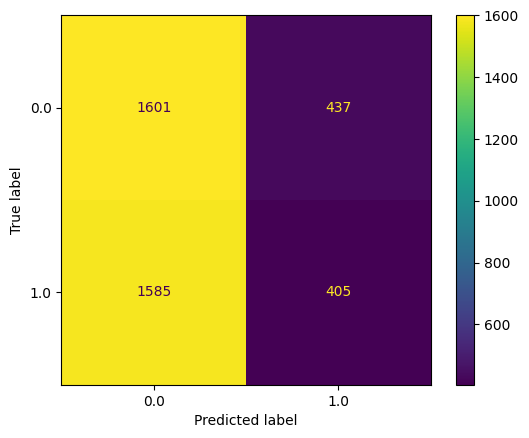

In [99]:
# visualize prediction accuracy
ConfusionMatrixDisplay.from_predictions(
    y_test, AA_lr_preds
);